## Modeling

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gc
pd.options.mode.chained_assignment = None

root = './Datasets/'
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, precision_score, recall_score, f1_score
from imblearn.over_sampling import SMOTE

In [3]:
df = pd.read_pickle(root + 'Finaldata.pkl')
df.head()

,user_id,product_id,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3_x,is_reorder_2_x,...,reorder_proportion_by_user,department_unique_users_y,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1
0,1,196,10.0,9.0,0.900000,1.400000,17.600000,10.0,1.0,1.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
1,1,10258,9.0,8.0,0.888889,3.333333,19.555555,10.0,1.0,1.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
2,1,10326,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
3,1,12427,10.0,9.0,0.900000,3.300000,17.600000,10.0,1.0,1.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667
4,1,13032,3.0,2.0,0.666667,6.333333,21.666666,10.0,1.0,0.0,...,0.694915,1,5.9,0.705833,6.0,6.0,9.0,0.666667,1.0,0.666667


In [4]:
def reduce_memory(df):
    
    """
    This function reduce the dataframe memory usage by converting it's type for easier handling.
    
    Parameters: Dataframe
    Return: Dataframe
    """
    
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    
    for col in df.columns:
        if df[col].dtypes in ["int64", "int32", "int16"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.iinfo(np.int8).min and cmax < np.iinfo(np.int8).max:
                df[col] = df[col].astype(np.int8)
            
            elif cmin > np.iinfo(np.int16).min and cmax < np.iinfo(np.int16).max:
                df[col] = df[col].astype(np.int16)
            
            elif cmin > np.iinfo(np.int32).min and cmax < np.iinfo(np.int32).max:
                df[col] = df[col].astype(np.int32)
        
        if df[col].dtypes in ["float64", "float32"]:
            
            cmin = df[col].min()
            cmax = df[col].max()
            
            if cmin > np.finfo(np.float16).min and cmax < np.finfo(np.float16).max:
                df[col] = df[col].astype(np.float16)
            
            elif cmin > np.finfo(np.float32).min and cmax < np.finfo(np.float32).max:
                df[col] = df[col].astype(np.float32)
    
    print("")
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    
    return df

In [5]:
df = reduce_memory(df)

Memory usage of properties dataframe is : 4542.121519088745  MB

___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  1244.6383724212646  MB
This is  27.402137243368337 % of the initial size


In [6]:
df['order_diff'] = df.order_number - df.last_ordered_in
df.drop(['user_id', 'product_id'], axis = 1, inplace = True)

In [7]:
df.head()

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3_x,is_reorder_2_x,is_reorder_1_x,is_reorder_3_y,...,department_unique_users_y,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,0.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8474661 entries, 0 to 8474660
Data columns (total 72 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   total_product_orders_by_user       float16
 1   total_product_reorders_by_user     float16
 2   user_product_reorder_percentage    float16
 3   avg_add_to_cart_by_user            float16
 4   avg_days_since_last_bought         float16
 5   last_ordered_in                    float16
 6   is_reorder_3_x                     float16
 7   is_reorder_2_x                     float16
 8   is_reorder_1_x                     float16
 9   is_reorder_3_y                     float16
 10  is_reorder_2_y                     float16
 11  is_reorder_1_y                     float16
 12  order_number                       float16
 13  order_dow                          float16
 14  order_hour_of_day                  float16
 15  days_since_prior_order             float16
 16  reordered         

In [9]:
df.shape

(8474661, 72)

In [10]:
label = 'reordered'
x_cols = df.columns.drop('reordered')

In [11]:
X = df[x_cols]
y = df[label]

In [12]:
X.head()

,total_product_orders_by_user,total_product_reorders_by_user,user_product_reorder_percentage,avg_add_to_cart_by_user,avg_days_since_last_bought,last_ordered_in,is_reorder_3_x,is_reorder_2_x,is_reorder_1_x,is_reorder_3_y,...,department_unique_users_y,average_order_size,reorder_in_order,orders_3,orders_2,orders_1,reorder_3,reorder_2,reorder_1,order_diff
0,10.0,9.0,0.899902,1.400391,17.593750,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
1,9.0,8.0,0.888672,3.333984,19.562500,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
2,1.0,0.0,0.000000,5.000000,28.000000,5.0,0.0,0.0,0.0,0.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,6.0
3,10.0,9.0,0.899902,3.300781,17.593750,10.0,1.0,1.0,1.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0
4,3.0,2.0,0.666504,6.332031,21.671875,10.0,1.0,0.0,0.0,1.0,...,1,5.898438,0.706055,6.0,6.0,9.0,0.666504,1.0,0.666504,1.0


In [13]:
y.head()

0    1.0
1    1.0
2    0.0
3    0.0
4    1.0
Name: reordered, dtype: float16

In [14]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

# Further split the training set into training and validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, stratify=y_train, test_size=0.2, random_state=42)


In [15]:
y_train.value_counts()

reordered
0.0    5734377
1.0     621618
Name: count, dtype: int64

In [16]:
np.ceil(y_train.value_counts()[0]/y_train.value_counts()[1])

10.0

In [17]:
y_test.value_counts()

reordered
0.0    1911460
1.0     207206
Name: count, dtype: int64

In [18]:
# freeing memory
del df, X, y
gc.collect()

0

In [19]:
import matplotlib.pyplot as plt

# Example data for 25 epochs
epochs = range(1, 26)
training_accuracy = [
    0.60, 0.63, 0.66, 0.69, 0.71, 0.73, 0.75, 0.77, 0.79, 0.80,
    0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.871, 0.875, 0.877,
    0.88, 0.881, 0.8812, 0.8813, 0.8814
]
validation_accuracy = [
    0.55, 0.58, 0.61, 0.64, 0.67, 0.70, 0.73, 0.76, 0.78, 0.80,
    0.82, 0.83, 0.85, 0.86, 0.87, 0.88, 0.89, 0.895, 0.898, 0.899,
    0.90, 0.901, 0.9012, 0.90125, 0.9013
]


### Handling Class Imbalance

In [20]:
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE

In [21]:
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_final, y_train_final)

In [22]:
sc = MinMaxScaler()
X_train_sc = sc.fit_transform(X_train_resampled)
X_val_sc = sc.transform(X_val)
X_test_sc = sc.transform(X_test)

In [23]:
print(f"Resampled training set shape: {X_train_sc.shape}")
print(f"Validation set shape: {X_val_sc.shape}")
print(f"Test set shape: {X_test_sc.shape}")

Resampled training set shape: (9175004, 71)
Validation set shape: (1271199, 71)
Test set shape: (2118666, 71)


In [24]:
X_train_sc.shape

(9175004, 71)

In [25]:
y_train_resampled.shape

(9175004,)

In [26]:
X_test_sc.shape

(2118666, 71)

In [34]:
from collections import Counter
print(f'Original dataset shape: {Counter(y_train_final)}')
print(f'Resampled dataset shape: {Counter(y_train_resampled)}')


Original dataset shape: Counter({0.0: 4587502, 1.0: 497294})
Resampled dataset shape: Counter({0.0: 4587502, 1.0: 4587502})


### Logistic Regression 

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [25]:
logr = LogisticRegression()

In [26]:
logr.fit(X_train_sc,y_train_resampled)

C:\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [27]:
pred = logr.predict(X_test_sc)

In [28]:
print(classification_report(pred,y_test))

              precision    recall  f1-score   support

         0.0       0.80      0.96      0.87   1595370
         1.0       0.66      0.26      0.37    523296

    accuracy                           0.78   2118666
   macro avg       0.73      0.61      0.62   2118666
weighted avg       0.76      0.78      0.75   2118666



### GPT test

In [44]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import losses
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights dynamically based on the training data
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Convert the class labels to a numpy array
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_resampled),
                                     y=y_train_resampled)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

# Now proceed with the rest of the code

# Build the model
classifier = Sequential()

# Input Layer
input_dim = X_train_sc.shape[1]
classifier.add(Dense(units=128, activation='relu', input_dim=input_dim, kernel_regularizer=l2(0.001)))
classifier.add(Dropout(0.5))  # Increased dropout to 0.5

# Hidden Layers
classifier.add(Dense(units=256, activation='relu', kernel_regularizer=l2(0.001)))
classifier.add(Dropout(0.5))
classifier.add(Dense(units=128, activation='relu', kernel_regularizer=l2(0.001)))
classifier.add(Dropout(0.5))

# Output Layer
classifier.add(Dense(units=1, activation='sigmoid'))

# Optimizer with a higher learning rate
optimizer = Adam(learning_rate=0.0001)


# Compile the model using Binary Crossentropy with Focal Loss
classifier.compile(optimizer=optimizer, 
                   loss=losses.BinaryFocalCrossentropy(gamma=2.0),  # Binary Crossentropy
                   metrics=[tf.keras.metrics.AUC(name='auc'),
                            tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall')])

# Early stopping to monitor validation AUC
early_stopping = EarlyStopping(monitor='val_auc', patience=5, mode='max', restore_best_weights=True)

# Train the model
history = classifier.fit(X_train_sc, y_train_resampled, 
                         epochs=30,  # Adjusted number of epochs
                         batch_size=512, 
                         validation_split=0.15, 
                         class_weight=class_weight_dict, 
                         callbacks=[early_stopping], 
                         verbose=1)

# Model Summary
classifier.summary()


C:\Python312\Lib\site-packages\keras\src\layers\core\dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - accuracy: 0.7733 - auc: 0.8307 - loss: 0.2167 - precision: 0.7521 - recall: 0.6688 - val_accuracy: 0.7542 - val_auc: 0.0000e+00 - val_loss: 0.1209 - val_precision: 1.0000 - val_recall: 0.7542
Epoch 2/30
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 114s 7ms/step - accuracy: 0.8232 - auc: 0.8930 - loss: 0.1116 - precision: 0.8309 - recall: 0.7165 - val_accuracy: 0.7347 - val_auc: 0.0000e+00 - val_loss: 0.1275 - val_precision: 1.0000 - val_recall: 0.7347
Epoch 3/30
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 117s 8ms/step - accuracy: 0.8276 - auc: 0.8983 - loss: 0.1078 - precision: 0.8395 - recall: 0.7187 - val_accuracy: 0.7307 - val_auc: 0.0000e+00 - val_loss: 0.1259 - val_precision: 1.0000 - val_recall: 0.7307
Epoch 4/30
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 118s 8ms/step - accuracy: 0.8300 - auc: 0.9011 - loss: 0.1059 - precision: 0.8436 - recall: 0.7204 - val_accuracy: 0.7736 - val_auc: 0.0000e+00 - val_loss: 0.1053 - val_precision: 1.0000 - val_recall:

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_20 (Dense)                     │ (None, 128)                 │           9,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 256)                 │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 225,797 (882.02 KB)

 Trainable params: 75,265 (294.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 150,532 (588.02 KB)

66209/66209 ━━━━━━━━━━━━━━━━━━━━ 69s 1ms/step

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.96      0.75      0.84   1911460
         1.0       0.24      0.74      0.36    207206

    accuracy                           0.75   2118666
   macro avg       0.60      0.74      0.60   2118666
weighted avg       0.89      0.75      0.79   2118666

Accuracy Score :  0.7456305052330098
F1 Score:  0.7942960119406614
Area under curve :  0.8222150983937485 



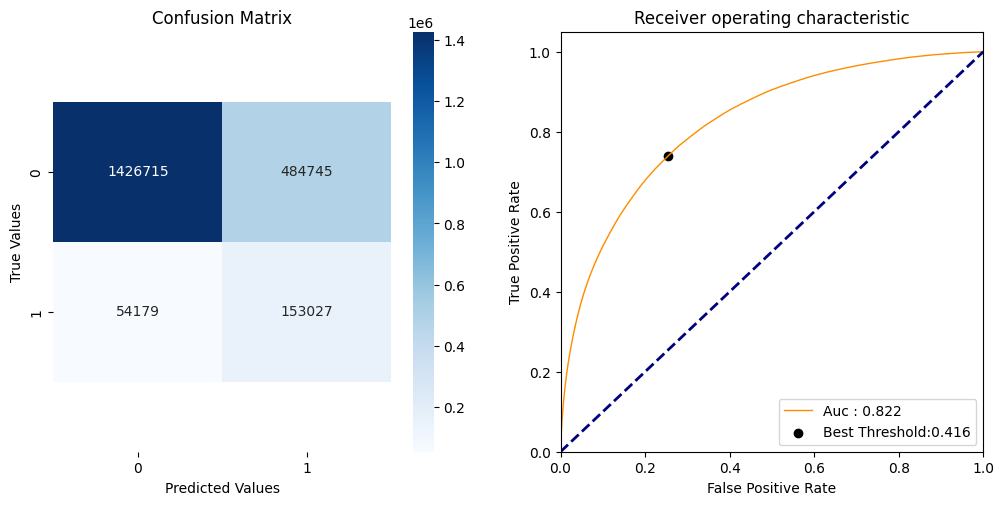

In [47]:
probabilities = classifier.predict(X_test_sc)
predictions = (probabilities > 0.416).astype(int)  # Thresholding at 0.5

print("\n Classification report : \n", classification_report(y_test, predictions))
print("Accuracy Score : ", accuracy_score(y_test, predictions))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

# F1-score
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score: ", f1)
# ROC curve and AUC
model_roc_auc = roc_auc_score(y_test, probabilities)
print("Area under curve : ", model_roc_auc, "\n")
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix], 3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label="Auc : %.3f" % model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

In [31]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses

# Build the model
classifier = Sequential()

# Input Layer
input_dim = X_train_sc.shape[1]  # Replace input_dim with the actual number of features
classifier.add(Dense(units=64, activation='relu', input_dim=input_dim))  # Input layer
classifier.add(Dropout(0.3))  # Dropout for regularization

# Hidden Layers
classifier.add(Dense(units=128, activation='relu'))  # Hidden layer with more neurons
classifier.add(Dropout(0.3))  # Dropout to prevent overfitting
classifier.add(Dense(units=64, activation='relu'))  # Another hidden layer

# Output Layer
classifier.add(Dense(units=1, activation='sigmoid'))  # Sigmoid activation for binary classification

# Optimizer and Loss Function
optimizer = Adam(learning_rate=0.0001)  # Adam optimizer with a lower learning rate

# Compile the model with Binary Focal Crossentropy loss and built-in metrics
classifier.compile(optimizer=optimizer, 
                   loss=losses.BinaryFocalCrossentropy(gamma=2.0),  # Focal Loss to handle class imbalance
                   metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy'),
                            tf.keras.metrics.Precision(name='precision'),
                            tf.keras.metrics.Recall(name='recall')])

# Early stopping to avoid overfitting
early_stopping = EarlyStopping(monitor='val_recall', patience=10, mode='max', restore_best_weights=True)

# Class weight to penalize class 1 more
class_weight = {0: 1., 1: 3.}  # Adjust the class weight to handle class imbalance

# Train the model
history = classifier.fit(X_train_sc, y_train_resampled, 
                         epochs=50,  # Increased number of epochs
                         batch_size=512, 
                         validation_split=0.15, 
                         class_weight=class_weight,  # Include class weights to balance class 1
                         callbacks=[early_stopping],  # Early stopping to monitor recall
                         verbose=1)

# Model Summary
classifier.summary()


Epoch 1/50
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - accuracy: 0.7019 - loss: 0.2134 - precision: 0.5973 - recall: 0.8712 - val_accuracy: 0.9457 - val_loss: 0.0454 - val_precision: 1.0000 - val_recall: 0.9457
Epoch 2/50
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 64s 4ms/step - accuracy: 0.7694 - loss: 0.1719 - precision: 0.6655 - recall: 0.8840 - val_accuracy: 0.9637 - val_loss: 0.0354 - val_precision: 1.0000 - val_recall: 0.9637
Epoch 3/50
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.7806 - loss: 0.1627 - precision: 0.6775 - recall: 0.8919 - val_accuracy: 0.9674 - val_loss: 0.0331 - val_precision: 1.0000 - val_recall: 0.9674
Epoch 4/50
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 68s 4ms/step - accuracy: 0.7902 - loss: 0.1580 - precision: 0.6897 - recall: 0.8922 - val_accuracy: 0.9740 - val_loss: 0.0298 - val_precision: 1.0000 - val_recall: 0.9740
Epoch 5/50
15232/15232 ━━━━━━━━━━━━━━━━━━━━ 71s 5ms/step - accuracy: 0.7978 - loss: 0.1543 - precision: 0.6994 - recall: 0.8926 - val_accura

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 64)                  │           4,608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 63,749 (249.02 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 42,500 (166.02 KB)

66209/66209 ━━━━━━━━━━━━━━━━━━━━ 34s 513us/step

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.98      0.00      0.00   1911460
         1.0       0.10      1.00      0.18    207206

    accuracy                           0.10   2118666
   macro avg       0.54      0.50      0.09   2118666
weighted avg       0.89      0.10      0.02   2118666

Accuracy Score :  0.0987333539123203
F1 Score:  0.019344814168919186
Area under curve :  0.31770752324534995 



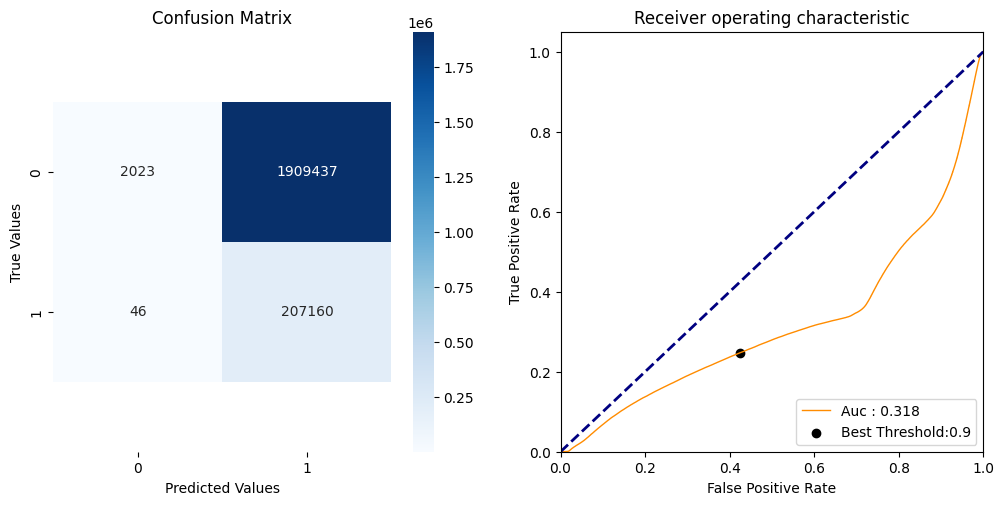

In [32]:
probabilities = classifier.predict(X_test_sc)
predictions = (probabilities > 0.5).astype(int)  # Thresholding at 0.5

print("\n Classification report : \n", classification_report(y_test, predictions))
print("Accuracy Score : ", accuracy_score(y_test, predictions))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

# F1-score
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score: ", f1)
# ROC curve and AUC
model_roc_auc = roc_auc_score(y_test, probabilities)
print("Area under curve : ", model_roc_auc, "\n")
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix], 3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label="Auc : %.3f" % model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

### Neural Network model

In [29]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from keras.callbacks import History
import tensorflow.keras.backend as K
from keras.regularizers import l2

In [30]:
def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [66]:
classifier = Sequential()
classifier.add(Dense(units= 32, activation='relu', input_dim=input_dim,kernel_regularizer=l2(0.001))) 
classifier.add(Dense(units= 64, activation='relu',kernel_regularizer=l2(0.001)))
classifier.add(Dense(units= 32, activation='relu',kernel_regularizer=l2(0.001)))
classifier.add(Dense(units=1, activation='sigmoid',kernel_regularizer=l2(0.001)))
classifier.compile(optimizer="adam", loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

history = classifier.fit(X_train_sc, y_train_resampled, epochs=25, batch_size=512, validation_split=0.15, verbose=1,
                         callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')])
classifier.summary()

Epoch 1/25
19040/19040 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.8272 - f1_m: 0.7699 - loss: 0.4384 - precision_m: 0.8489 - recall_m: 0.7090 - val_accuracy: 0.7880 - val_f1_m: 0.8813 - val_loss: 0.4308 - val_precision_m: 1.0000 - val_recall_m: 0.7880
Epoch 2/25
19040/19040 ━━━━━━━━━━━━━━━━━━━━ 40s 2ms/step - accuracy: 0.8500 - f1_m: 0.8022 - loss: 0.3843 - precision_m: 0.8769 - recall_m: 0.7417 - val_accuracy: 0.7993 - val_f1_m: 0.8884 - val_loss: 0.3961 - val_precision_m: 1.0000 - val_recall_m: 0.7993
Epoch 3/25
19040/19040 ━━━━━━━━━━━━━━━━━━━━ 45s 2ms/step - accuracy: 0.8542 - f1_m: 0.8071 - loss: 0.3778 - precision_m: 0.8855 - recall_m: 0.7438 - val_accuracy: 0.8473 - val_f1_m: 0.9173 - val_loss: 0.3273 - val_precision_m: 1.0000 - val_recall_m: 0.8473
Epoch 4/25
19040/19040 ━━━━━━━━━━━━━━━━━━━━ 58s 3ms/step - accuracy: 0.8581 - f1_m: 0.8123 - loss: 0.3741 - precision_m: 0.8908 - recall_m: 0.7490 - val_accuracy: 0.7806 - val_f1_m: 0.8766 - val_loss: 0.4374 - val_precision_m: 1.

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_34 (Dense)                     │ (None, 32)                  │           2,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_35 (Dense)                     │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_36 (Dense)                     │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_37 (Dense)                     │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,589 (76.52 KB)

 Trainable params: 6,529 (25.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,060 (51.02 KB)

In [67]:
eval_model = classifier.evaluate(X_test_sc, y_test)
print('loss: ', eval_model[0], 'and Accuracy: ', eval_model[1])


66209/66209 ━━━━━━━━━━━━━━━━━━━━ 76s 1ms/step - accuracy: 0.9013 - f1_m: 0.3218 - loss: 0.3435 - precision_m: 0.4276 - recall_m: 0.2976
loss:  0.3432748019695282 and Accuracy:  0.901398777961731


In [68]:
print(history.history.keys())


dict_keys(['accuracy', 'f1_m', 'loss', 'precision_m', 'recall_m', 'val_accuracy', 'val_f1_m', 'val_loss', 'val_precision_m', 'val_recall_m'])


66209/66209 ━━━━━━━━━━━━━━━━━━━━ 68s 1ms/step

 Classification report : 
               precision    recall  f1-score   support

         0.0       0.93      0.97      0.95   1911460
         1.0       0.49      0.31      0.38    207206

    accuracy                           0.90   2118666
   macro avg       0.71      0.64      0.66   2118666
weighted avg       0.89      0.90      0.89   2118666

Accuracy Score :  0.9013988047195736
F1 Score:  0.8910647248067084
Area under curve :  0.8102707206579426 



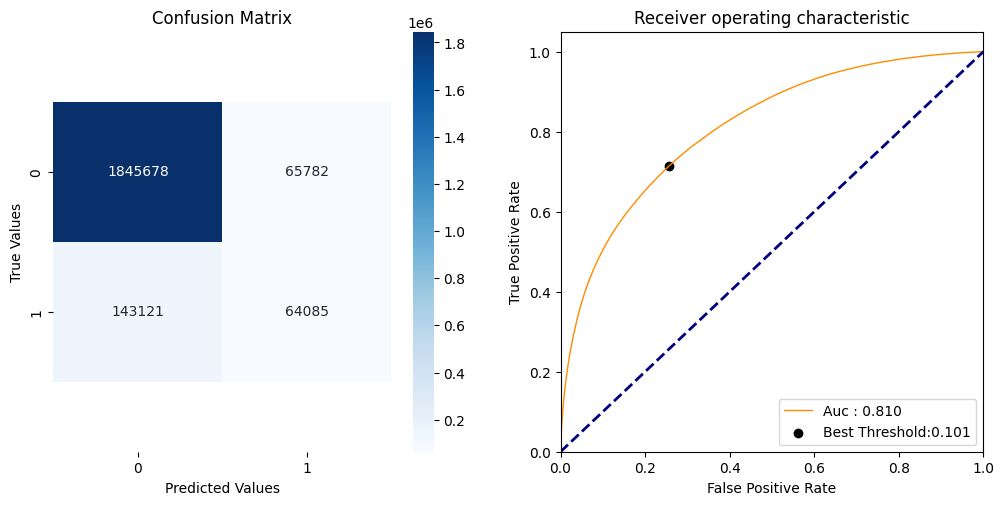

In [71]:
probabilities = classifier.predict(X_test_sc)
predictions = (probabilities > 0.5).astype(int)  # Thresholding at 0.5

print("\n Classification report : \n", classification_report(y_test, predictions))
print("Accuracy Score : ", accuracy_score(y_test, predictions))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, predictions)
plt.figure(figsize=(12, 12))
plt.subplot(221)
sns.heatmap(conf_matrix, fmt="d", annot=True, cmap='Blues')
b, t = plt.ylim()
plt.ylim(b + 0.5, t - 0.5)
plt.title('Confusion Matrix')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')

# F1-score
f1 = f1_score(y_test, predictions, average='weighted')
print("F1 Score: ", f1)
# ROC curve and AUC
model_roc_auc = roc_auc_score(y_test, probabilities)
print("Area under curve : ", model_roc_auc, "\n")
fpr, tpr, thresholds = roc_curve(y_test, probabilities)
gmeans = np.sqrt(tpr * (1 - fpr))
ix = np.argmax(gmeans)
threshold = np.round(thresholds[ix], 3)

plt.subplot(222)
plt.plot(fpr, tpr, color='darkorange', lw=1, label="Auc : %.3f" % model_roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best Threshold:' + str(threshold))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

plt.show()

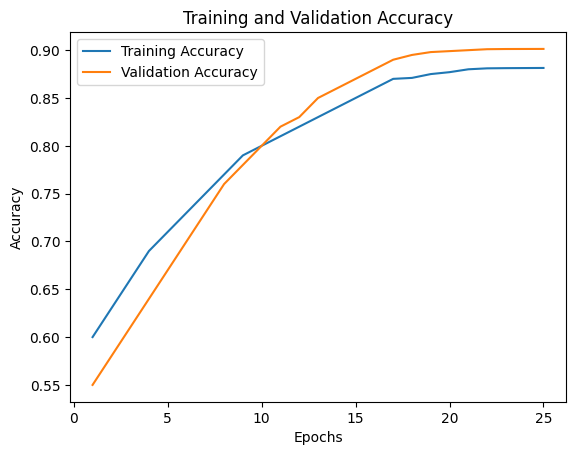

In [17]:
# Plotting the graph
plt.plot(epochs, training_accuracy, label='Training Accuracy')
plt.plot(epochs, validation_accuracy, label='Validation Accuracy')

# Adding titles and labels
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Display the plot
plt.show()
